In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
data_file_path = "/content/gestures.csv" #court data
data = pd.read_csv(data_file_path)
train, test = train_test_split(data, test_size=0.2)
y_train, y_test = train['class'], test['class']
x_train, x_test = train.copy(), test.copy()
x_train.drop(['class', 'id'], axis=1, inplace=True)
x_test.drop(['class', 'id'], axis=1, inplace=True)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression


logreg = LogisticRegression()

logreg.fit(x_train, y_train)

y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

# print(y_train_pred[:10])
# print(y_test_pred[:10])

In [ ]:
def get_accuracy(real, pred):
    sum = 0
    for i in range(len(real)):
        if real[i] == pred[i]:
            sum += 1
    return sum / len(real) * 100

In [ ]:
def get_weights(model_, feature_names):
    if hasattr(model_, 'coef_'):
        coefficients = model_.coef_[0]
    elif hasattr(model_, 'feature_log_prob_'):
        # For Bernoulli Naive Bayes
        coefficients = model_.feature_log_prob_[0]
    else:
        raise AttributeError("Model does not have 'coef_' or 'feature_log_prob_' attribute.")

    feature_coefficients = list(zip(feature_names, coefficients))
    return feature_coefficients
    # top_features = sorted(feature_coefficients, key=lambda x: abs(x[1]), reverse=True)


In [ ]:
logreg_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
logreg_test_acc = get_accuracy(y_test.tolist(), y_test_pred)
logreg_weights = get_weights(logreg, x_train.columns.values.tolist())

# print(logreg_train_acc)
# print(logreg_test_acc)

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB


bayes = BernoulliNB()
bayes.fit(x_train, y_train)

y_train_pred = bayes.predict(x_train)
y_test_pred = bayes.predict(x_test)

In [ ]:
bayes_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
bayes_test_acc = get_accuracy(y_test.tolist(), y_test_pred)
bayes_weights = get_weights(bayes, x_train.columns.values.tolist())

## GDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


gda = LinearDiscriminantAnalysis()
gda.fit(x_train, y_train)

y_train_pred = gda.predict(x_train)
y_test_pred = gda.predict(x_test)

In [ ]:
gda_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
gda_test_acc = get_accuracy(y_test.tolist(), y_test_pred)
gda_weights = get_weights(gda, x_train.columns.values.tolist())

## SVM

In [ ]:
from sklearn import svm


clf  = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)

y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

In [ ]:
svm_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
svm_test_acc = get_accuracy(y_test.tolist(), y_test_pred)
# svm_weights = get_weights(clf, x_train.columns.values.tolist())

## Neural Network

In [ ]:
y_train.replace({'truthful': 0, 'deceptive': 1}, inplace=True)
y_test.replace({'truthful': 0, 'deceptive': 1}, inplace=True)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the model, loss function, and optimizer
input_size = 39 # Assuming x_train is a list of input features
hidden_size = 64
output_size = 1  # For binary classification
nn_model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(nn_model.parameters(), lr=0.01)

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = nn_model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    # if (epoch + 1) % 100 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    nn_model.eval()
    test_outputs = nn_model(x_test_tensor)
    test_predictions = (test_outputs >= 0.5).float()
    test_loss = criterion(test_predictions, y_test_tensor)
    # print(f'Test Loss: {test_loss.item():.4f}')

    # Calculate and print test accuracy
    nn_test_acc = get_accuracy(test_predictions, y_test_tensor)
    # print(f'Test Accuracy: {nn_test_acc:.4f}')

# Calculate and print training accuracy
with torch.no_grad():
    nn_model.eval()
    train_outputs = nn_model(x_train_tensor)
    train_predictions = (train_outputs >= 0.5).float()
    nn_train_acc = get_accuracy(train_predictions, y_train_tensor)
    # print(f'Training Accuracy: {nn_train_acc:.4f}')


## Analysis

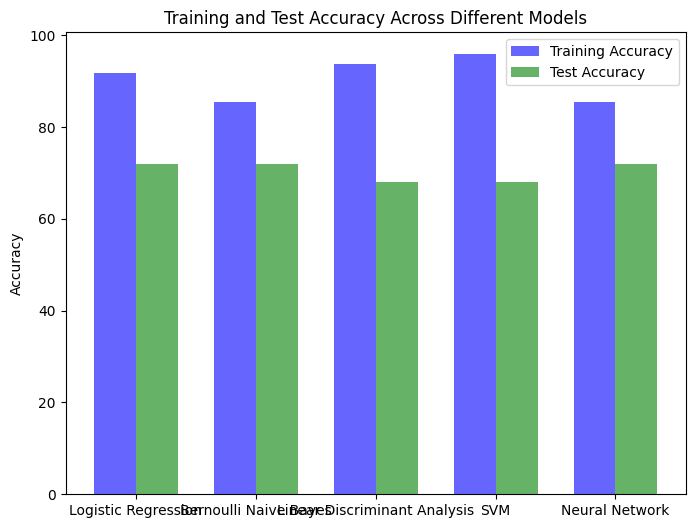

Logistic Regression Accuracy:  72.0 
 Naive Bayes Accuracy:  72.0 
 Linear Discriminant Analysis Accuracy:  68.0 
 Support Vector Machine Accuracy:  68.0 
 Neural Net Accuracy:  72.0 



In [ ]:
import matplotlib.pyplot as plt

# Define the model names and their corresponding accuracy values
models = ["Logistic Regression", "Bernoulli Naive Bayes", "Linear Discriminant Analysis", "SVM", "Neural Network"]
train_accuracy = [logreg_train_acc, bayes_train_acc, gda_train_acc, svm_train_acc, nn_train_acc]
test_accuracy = [logreg_test_acc, bayes_test_acc, gda_test_acc, svm_test_acc, nn_test_acc]
bar_width = 0.35
x = range(len(models))
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(x, train_accuracy, bar_width, label='Training Accuracy', color='b', alpha=0.6)
plt.bar([i + bar_width for i in x], test_accuracy, bar_width, label='Test Accuracy', color='g', alpha=0.6)
plt.xticks([i + bar_width / 2 for i in x], models)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Across Different Models')
plt.show()

print(
    "Logistic Regression Accuracy: ", logreg_test_acc, "\n",
    "Naive Bayes Accuracy: ", bayes_test_acc, "\n",
    "Linear Discriminant Analysis Accuracy: ", gda_test_acc, "\n",
    "Support Vector Machine Accuracy: ", svm_test_acc, "\n",
    "Neural Net Accuracy: ", nn_test_acc, "\n",
    )

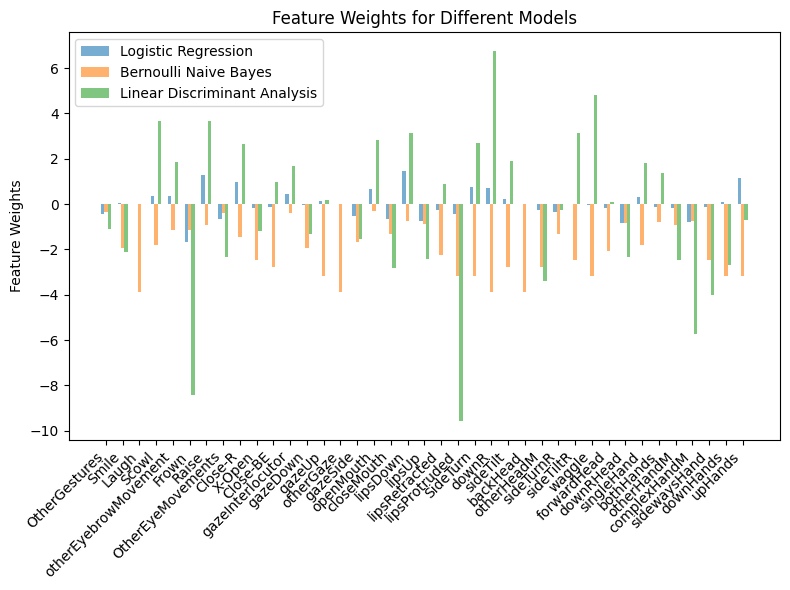

In [ ]:
import numpy as np


feature_names = [f[0] for f in logreg_weights]
model1_weights = [f[1] for f in logreg_weights]
model2_weights = [f[1] for f in bayes_weights]
model3_weights = [f[1] for f in gda_weights]
bar_width = 0.2
x = np.arange(len(feature_names))
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(x - bar_width, model1_weights, bar_width, label='Logistic Regression', alpha=0.6)
plt.bar(x, model2_weights, bar_width, label='Bernoulli Naive Bayes', alpha=0.6)
plt.bar(x + bar_width, model3_weights, bar_width, label='Linear Discriminant Analysis', alpha=0.6)
plt.xticks(x, feature_names, rotation=45, ha="right")
plt.ylabel('Feature Weights')
plt.title('Feature Weights for Different Models')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Define the model names and weights
models = ["Logistic Regression", "Bernoulli Naive Bayes", "Linear Discriminant Analysis"]
weights = [model1_weights, model2_weights, model3_weights]

# Set the number of top features to display
top_features_count = 5  # Change this number based on your preference

# Iterate through each model and print the most important feature weights
for model_name, model_weights in zip(models, weights):
    print(f"{model_name} Top {top_features_count} Important Feature Weights:")

    # Sort features based on their weights
    sorted_features = sorted(zip(feature_names, model_weights), key=lambda x: abs(x[1]), reverse=True)

    # Print the top features and their weights
    for feature, weight in sorted_features[:top_features_count]:
        print(f"{feature}: {weight}")

    print("\n")


Logistic Regression Top 5 Important Feature Weights:
Frown: -1.654068332219512
lipsDown: 1.4660941854001663
Raise: 1.299502331138967
upHands: 1.1312730535976887
Close-R: 0.9777134429584029


Bernoulli Naive Bayes Top 5 Important Feature Weights:
Laugh: -3.871201010907891
otherGaze: -3.871201010907891
downR: -3.871201010907891
backHead: -3.871201010907891
gazeUp: -3.1780538303479458


Linear Discriminant Analysis Top 5 Important Feature Weights:
lipsProtruded: -9.590493508997534
Frown: -8.411073909568955
downR: 6.761108001743267
complexHandM: -5.727857205672619
waggle: 4.828417407743949




# Testing

Here we tested against our own generated data

In [ ]:
generated_data_file_path = "/content/generated.csv"
generated_data = pd.read_csv(generated_data_file_path)
actual_results = generated_data['Bluff']

In [ ]:
data = generated_data.drop(['Round', 'Person', 'Bluff'], axis=1)

In [ ]:
#pandas type
logreg_predictions = logreg.predict(data)
bayes_predictions = bayes.predict(data)
gda_predictions = gda.predict(data)
svm_predictions = clf.predict(data)
with torch.no_grad():
    x_test_tensor = torch.tensor(data.values, dtype=torch.float32)
    nn_model.eval()
    test_outputs = nn_model(x_test_tensor)
    nn_predictions = (test_outputs >= 0.5).float()

# print(len(nn_predictions.numpy().reshape(1, -1)[0]))
# print(svm_predictions)
predictions_df = pd.DataFrame({
    'Logistic Regression': logreg_predictions,
    'Naive Bayes': bayes_predictions,
    'Linear Discriminant Analysis': gda_predictions,
    'SVM': svm_predictions,
    'Neural Network': nn_predictions.numpy().reshape(1, -1)[0]
})

# print(predictions_df)
# print(logreg_predictions)

In [ ]:
from sklearn.metrics import classification_report


# Map 'truthful' and 'deceptive' to 0s and 1s directly
predictions_df.replace({'truthful': 0, 'deceptive': 1}, inplace=True)

# print(predictions_df)
# print(actual_results)
combined_df = pd.concat([actual_results, predictions_df], axis=1)
# print(combined_df)


In [ ]:
for model in predictions_df.columns:
    print(f"Classification Report for {model}:")
    print(classification_report(actual_results, predictions_df[model]))
    print()

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.25      0.38        16
           1       0.37      0.88      0.52         8

    accuracy                           0.46        24
   macro avg       0.58      0.56      0.45        24
weighted avg       0.66      0.46      0.43        24


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.67      0.88      0.76        16
           1       0.33      0.12      0.18         8

    accuracy                           0.62        24
   macro avg       0.50      0.50      0.47        24
weighted avg       0.56      0.62      0.57        24


Classification Report for Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       0.67      0.12      0.21        16
           1       0.33      0.88      0.48         8

    accuracy                          

In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each model
accuracy_logreg = accuracy_score(actual_results, predictions_df['Logistic Regression'])
accuracy_bayes = accuracy_score(actual_results, predictions_df['Naive Bayes'])
accuracy_gda = accuracy_score(actual_results, predictions_df['Linear Discriminant Analysis'])
accuracy_svm = accuracy_score(actual_results, predictions_df['SVM'])
accuracy_nn = accuracy_score(actual_results, predictions_df['Neural Network'])


# Print the accuracies
print(f"Overall Accuracy for Logistic Regression: {accuracy_logreg * 100:.2f}%")
print(f"Overall Accuracy for Naive Bayes: {accuracy_bayes * 100:.2f}%")
print(f"Overall Accuracy for Linear Discriminant Analysis: {accuracy_gda * 100:.2f}%")
print(f"Overall Accuracy for SVM: {accuracy_svm * 100:.2f}%")
print(f"Overall Accuracy for Neural Networks: {accuracy_nn * 100:.2f}%")

Overall Accuracy for Logistic Regression: 45.83%
Overall Accuracy for Naive Bayes: 62.50%
Overall Accuracy for Linear Discriminant Analysis: 37.50%
Overall Accuracy for SVM: 66.67%
Overall Accuracy for Neural Networks: 58.33%


# Re-Training


As seen earlier, certain features were more important in the models than others. Examining which features had the biggest features, we selected a few to use for the poker dataset we would be creating. The features we chose are: Smile, Laugh, Scowl, Frown, Raise, X-Open, Close-BE, OtherEyeMovements, Close-R, gazeUp, gazeDown, gazeSide, forwardHead, backHead, sideTilt, sideTiltR, waggle, openMouth, downR, downRHead, SideTurn, upHand, downHand, sidewaysHand, complexHandM. Therefore, we decided to train the models again on just these features. We would then compare how these simpler models compare to the results above.

In [ ]:
data_file_path = "gestures.csv" #court data
data = pd.read_csv(data_file_path)
train, test = train_test_split(data, test_size=0.2)
y_train, y_test = train['class'], test['class']
x_train, x_test = train.copy(), test.copy()
drop_feats = ['class', 'id', 'OtherGestures', 'otherEyebrowMovement', 'OtherEyeMovements',
              'X-Open', 'gazeInterlocutor', 'otherGaze', 'closeMouth', 'lipsDown',
              'lipsUp', 'lipsRetracted', 'lipsProtruded', 'downR', 'otherHeadM', 'sideTurnR',
              'downRHead', 'singleHand', 'bothHands', 'otherHandM']
x_train.drop(drop_feats, axis=1, inplace=True)
x_test.drop(drop_feats, axis=1, inplace=True)

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_train_pred = logreg.predict(x_train)
y_test_pred = logreg.predict(x_test)

logreg_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
logreg_test_acc = get_accuracy(y_test.tolist(), y_test_pred)
logreg_weights = get_weights(logreg, x_train.columns.values.tolist())

In [ ]:
bayes = BernoulliNB()
bayes.fit(x_train, y_train)
y_train_pred = bayes.predict(x_train)
y_test_pred = bayes.predict(x_test)

bayes_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
bayes_test_acc = get_accuracy(y_test.tolist(), y_test_pred)
bayes_weights = get_weights(bayes, x_train.columns.values.tolist())

In [ ]:
gda = LinearDiscriminantAnalysis()
gda.fit(x_train, y_train)
y_train_pred = gda.predict(x_train)
y_test_pred = gda.predict(x_test)

gda_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
gda_test_acc = get_accuracy(y_test.tolist(), y_test_pred)
gda_weights = get_weights(gda, x_train.columns.values.tolist())

In [ ]:
clf  = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)

svm_train_acc = get_accuracy(y_train.tolist(), y_train_pred)
svm_test_acc = get_accuracy(y_test.tolist(), y_test_pred)

In [ ]:
y_train.replace({'truthful': 0, 'deceptive': 1}, inplace=True)
y_test.replace({'truthful': 0, 'deceptive': 1}, inplace=True)

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the model, loss function, and optimizer
input_size = 21 # Assuming x_train is a list of input features
hidden_size = 64
output_size = 1  # For binary classification
nn_model = SimpleNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.SGD(nn_model.parameters(), lr=0.01)

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Training the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = nn_model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss every 100 epochs
    # if (epoch + 1) % 100 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation on the test set
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    nn_model.eval()
    test_outputs = nn_model(x_test_tensor)
    test_predictions = (test_outputs >= 0.5).float()
    test_loss = criterion(test_predictions, y_test_tensor)
    # print(f'Test Loss: {test_loss.item():.4f}')

    # Calculate and print test accuracy
    nn_test_acc = get_accuracy(test_predictions, y_test_tensor)
    # print(f'Test Accuracy: {nn_test_acc:.4f}')

# Calculate and print training accuracy
with torch.no_grad():
    nn_model.eval()
    train_outputs = nn_model(x_train_tensor)
    train_predictions = (train_outputs >= 0.5).float()
    nn_train_acc = get_accuracy(train_predictions, y_train_tensor)
    # print(f'Training Accuracy: {nn_train_acc:.4f}')

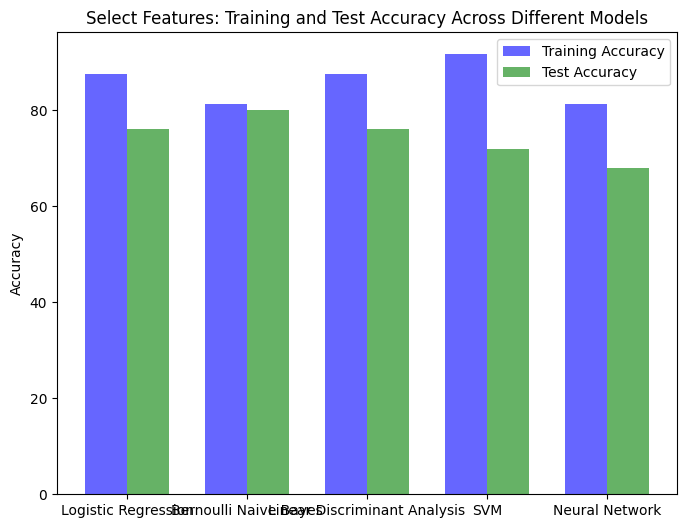

Logistic Regression Accuracy:  76.0 
 Naive Bayes Accuracy:  80.0 
 Linear Discriminant Analysis Accuracy:  76.0 
 Support Vector Machine Accuracy:  72.0 
 Neural Net Accuracy:  68.0 



In [ ]:
models = ["Logistic Regression", "Bernoulli Naive Bayes", "Linear Discriminant Analysis", "SVM", "Neural Network"]
train_accuracy = [logreg_train_acc, bayes_train_acc, gda_train_acc, svm_train_acc, nn_train_acc]
test_accuracy = [logreg_test_acc, bayes_test_acc, gda_test_acc, svm_test_acc, nn_test_acc]
bar_width = 0.35
x = range(len(models))
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(x, train_accuracy, bar_width, label='Training Accuracy', color='b', alpha=0.6)
plt.bar([i + bar_width for i in x], test_accuracy, bar_width, label='Test Accuracy', color='g', alpha=0.6)
plt.xticks([i + bar_width / 2 for i in x], models)
plt.legend()
plt.ylabel('Accuracy')
plt.title('Select Features: Training and Test Accuracy Across Different Models')
plt.show()

print(
    "Logistic Regression Accuracy: ", logreg_test_acc, "\n",
    "Naive Bayes Accuracy: ", bayes_test_acc, "\n",
    "Linear Discriminant Analysis Accuracy: ", gda_test_acc, "\n",
    "Support Vector Machine Accuracy: ", svm_test_acc, "\n",
    "Neural Net Accuracy: ", nn_test_acc, "\n",
    )

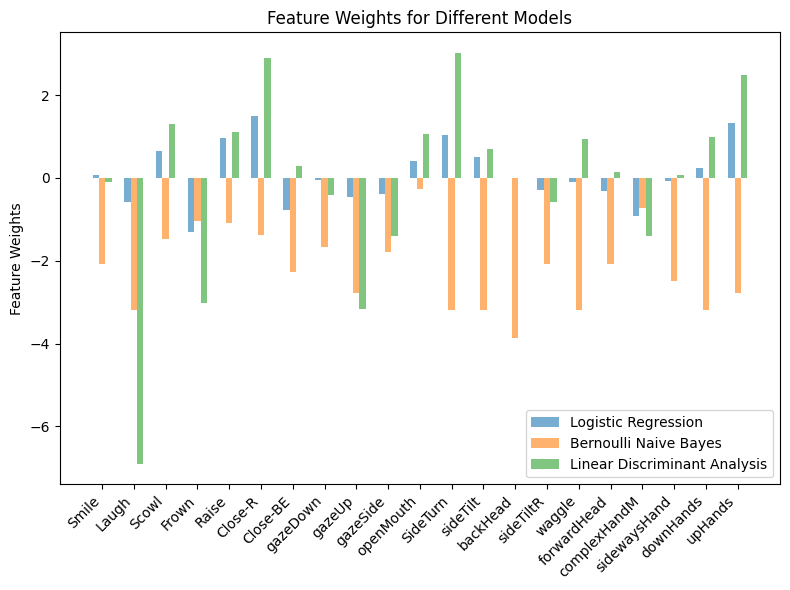

In [ ]:
import numpy as np


feature_names = [f[0] for f in logreg_weights]
model1_weights = [f[1] for f in logreg_weights]
model2_weights = [f[1] for f in bayes_weights]
model3_weights = [f[1] for f in gda_weights]
bar_width = 0.2
x = np.arange(len(feature_names))
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(x - bar_width, model1_weights, bar_width, label='Logistic Regression', alpha=0.6)
plt.bar(x, model2_weights, bar_width, label='Bernoulli Naive Bayes', alpha=0.6)
plt.bar(x + bar_width, model3_weights, bar_width, label='Linear Discriminant Analysis', alpha=0.6)
plt.xticks(x, feature_names, rotation=45, ha="right")
plt.ylabel('Feature Weights')
plt.title('Feature Weights for Different Models')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Define the model names and weights
models = ["Logistic Regression", "Bernoulli Naive Bayes", "Linear Discriminant Analysis"]
weights = [model1_weights, model2_weights, model3_weights]

# Set the number of top features to display
top_features_count = 5  # Change this number based on your preference

# Iterate through each model and print the most important feature weights
for model_name, model_weights in zip(models, weights):
    print(f"{model_name} Top {top_features_count} Important Feature Weights:")

    # Sort features based on their weights
    sorted_features = sorted(zip(feature_names, model_weights), key=lambda x: abs(x[1]), reverse=True)

    # Print the top features and their weights
    for feature, weight in sorted_features[:top_features_count]:
        print(f"{feature}: {weight}")

    print("\n")


Logistic Regression Top 5 Important Feature Weights:
Close-R: 1.483736427797438
upHands: 1.33713901231813
Frown: -1.2946596111491684
SideTurn: 1.0385958939647206
Raise: 0.961052038902934


Bernoulli Naive Bayes Top 5 Important Feature Weights:
backHead: -3.871201010907891
Laugh: -3.1780538303479458
SideTurn: -3.1780538303479458
sideTilt: -3.1780538303479458
waggle: -3.1780538303479458


Linear Discriminant Analysis Top 5 Important Feature Weights:
Laugh: -6.901247576631349
gazeUp: -3.1756225463363967
SideTurn: 3.0183750952839645
Frown: -3.0112144669410004
Close-R: 2.8980736408531627





# Top 5 most important features before dropping columns:

### Logistic Regression Top 5 Important Feature Weights:

lipsDown: 1.4137463361982874

Frown: -1.319534338522022

Raise: 1.1319672544675854

downRHead: -1.0494000869390132

Close-R: 0.9609105752950029


### Bernoulli Naive Bayes Top 5 Important Feature Weights:

otherGaze: -3.8918202981106265

backHead: -3.8918202981106265

Laugh: -3.198673117550681

gazeUp: -3.198673117550681

lipsProtruded: -3.198673117550681



### Linear Discriminant Analysis Top 5 Important Feature Weights:

lipsProtruded: -7.267961266412902

Frown: -4.680273066581028

sideTilt: 4.185027410251214

SideTurn: 3.713754991431701

Close-BE: -3.551836166745436


# Top 5 most important features after dropping columns:

### Logistic Regression Top 5 Important Feature Weights:

Close-R: 1.5135375736435783

SideTurn: 1.3481234500837986

upHands: 1.2043078783562782

complexHandM: -1.132937024492995

Raise: 1.0976359714519588


### Bernoulli Naive Bayes Top 5 Important Feature Weights:

SideTurn: -3.912023005428146

backHead: -3.912023005428146

Laugh: -3.2188758248682006

gazeUp: -3.2188758248682006

waggle: -3.2188758248682006


### Linear Discriminant Analysis Top 5 Important Feature Weights:

Laugh: -5.703580419040847

SideTurn: 3.6150415187120957

waggle: 3.379517045224501

Close-R: 2.8403809830557125

sideTilt: 2.4234921198643486


As seen above, the overall accuracy did not significantly drop despite removing several features. Removing these features will make the model more specific to our curated dataset.

# Re-Testing

In [ ]:
generated_data_file_path = "/content/generated.csv"
generated_data = pd.read_csv(generated_data_file_path)
actual_results = generated_data['Bluff']
drop_feats = ['Round', 'Person', 'Bluff', 'OtherGestures', 'otherEyebrowMovement', 'OtherEyeMovements',
              'X-Open', 'gazeInterlocutor', 'otherGaze', 'closeMouth', 'lipsDown',
              'lipsUp', 'lipsRetracted', 'lipsProtruded', 'downR', 'otherHeadM', 'sideTurnR',
              'downRHead', 'singleHand', 'bothHands', 'otherHandM']
data = generated_data.drop(drop_feats, axis=1)

In [ ]:
logreg_predictions = logreg.predict(data)
bayes_predictions = bayes.predict(data)
gda_predictions = gda.predict(data)
svm_predictions = clf.predict(data)
with torch.no_grad():
    x_test_tensor = torch.tensor(data.values, dtype=torch.float32)
    nn_model.eval()
    test_outputs = nn_model(x_test_tensor)
    nn_predictions = (test_outputs >= 0.5).float()

predictions_df = pd.DataFrame({
    'Logistic Regression': logreg_predictions,
    'Naive Bayes': bayes_predictions,
    'Linear Discriminant Analysis': gda_predictions,
    'SVM': svm_predictions,
    'Neural Network': nn_predictions.numpy().reshape(1, -1)[0]
})

predictions_df.replace({'truthful': 0, 'deceptive': 1}, inplace=True)

combined_df = pd.concat([actual_results, predictions_df], axis=1)
for model in predictions_df.columns:
    print(f"Classification Report for {model}:")
    print(classification_report(actual_results, predictions_df[model]))
    print()

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      0.38      0.55        16
           1       0.44      1.00      0.62         8

    accuracy                           0.58        24
   macro avg       0.72      0.69      0.58        24
weighted avg       0.81      0.58      0.57        24


Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       0.50      0.88      0.64         8

    accuracy                           0.67        24
   macro avg       0.70      0.72      0.66        24
weighted avg       0.77      0.67      0.67        24


Classification Report for Linear Discriminant Analysis:
              precision    recall  f1-score   support

           0       1.00      0.31      0.48        16
           1       0.42      1.00      0.59         8

    accuracy                          

In [ ]:
accuracy_logreg = accuracy_score(actual_results, predictions_df['Logistic Regression'])
accuracy_bayes = accuracy_score(actual_results, predictions_df['Naive Bayes'])
accuracy_gda = accuracy_score(actual_results, predictions_df['Linear Discriminant Analysis'])
accuracy_svm = accuracy_score(actual_results, predictions_df['SVM'])
accuracy_nn = accuracy_score(actual_results, predictions_df['Neural Network'])


# Print the accuracies
print(f"Overall Accuracy for Logistic Regression: {accuracy_logreg * 100:.2f}%")
print(f"Overall Accuracy for Naive Bayes: {accuracy_bayes * 100:.2f}%")
print(f"Overall Accuracy for Linear Discriminant Analysis: {accuracy_gda * 100:.2f}%")
print(f"Overall Accuracy for SVM: {accuracy_svm * 100:.2f}%")
print(f"Overall Accuracy for Neural Network: {accuracy_nn * 100:.2f}%")

Overall Accuracy for Logistic Regression: 58.33%
Overall Accuracy for Naive Bayes: 66.67%
Overall Accuracy for Linear Discriminant Analysis: 54.17%
Overall Accuracy for SVM: 54.17%
Overall Accuracy for Neural Network: 58.33%


Interestingly, when dropping the other low impact features, the model performance actually drops, meaning the first results we saw were better. However, Naive Bayes did perform significantly better with these adjustments.